# Spatial features

Find largest distance in current dataset for normalization!

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [26]:
from pathlib import Path
import pickle
import sys

import pandas as pd

from kinsim_structure.auxiliary import KlifsMoleculeLoader, PdbChainLoader
from kinsim_structure.encoding import Fingerprint, PhysicoChemicalFeatures, SpatialFeatures
from kinsim_structure.encoding import PharmacophoreSizeFeatures, SideChainOrientationFeature, ExposureFeature

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results'

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path)

In [7]:
klifs_metadata_entry = klifs_metadata.iloc[250]

## Maximum distance per molecule and per reference point

In [19]:
space = SpatialFeatures()

max_per_molecule = []

for index, row in klifs_metadata.iterrows():
    
    ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
    space.from_molecule(ml.molecule)
    
    max_per_molecule.append(space.features.max(axis=0))

In [22]:
max_distances = pd.DataFrame(max_per_molecule)

In [25]:
max_distances

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
0,22.65,25.62,27.98,26.89
1,22.85,25.31,28.08,26.56
2,23.63,24.71,28.69,26.68
3,20.98,23.72,26.44,25.75
4,21.84,22.54,28.11,23.29
5,21.43,23.33,26.33,24.14
6,20.81,23.74,25.95,25.08
7,22.41,23.78,27.93,NaN
8,21.21,23.69,26.07,24.32
9,21.07,23.70,26.91,25.79


### Save data

In [27]:
with open(path_to_results / 'distances_max.p', 'wb') as f:
    pickle.dump(max_distances, f)

### Load and plot data

In [51]:
with open(path_to_results / 'distances_max.p', 'rb') as f:
    max_distances = pickle.load(f)

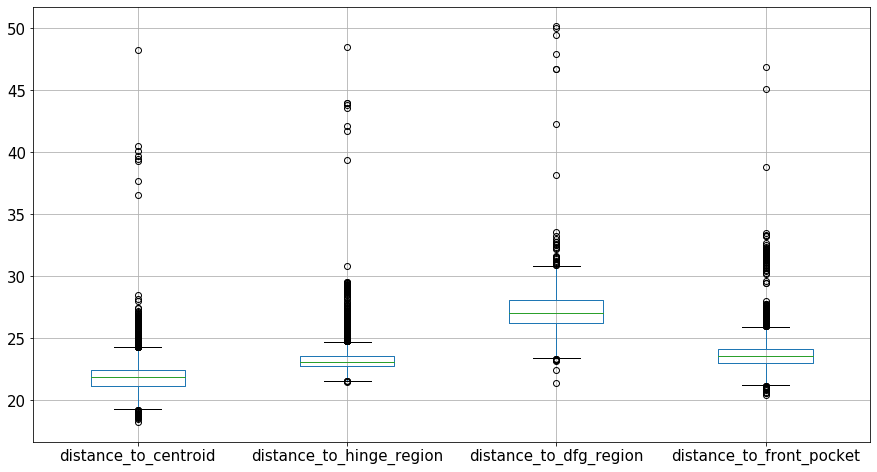

In [52]:
boxplot = max_distances.boxplot(figsize=(15,8), fontsize=15)

In [40]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_max_boxplot.png', dpi=300)

### Look at some of those >40 distances

In [45]:
max_distances[max_distances.distance_to_centroid > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [46]:
max_distances[max_distances.distance_to_hinge_region > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [47]:
max_distances[max_distances.distance_to_dfg_region > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [48]:
max_distances[max_distances.distance_to_front_pocket > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2833,48.20,48.51,47.91,38.83


In [50]:
klifs_metadata.index

RangeIndex(start=0, stop=3917, step=1)

In [49]:
klifs_metadata.iloc[830]

Unnamed: 0                                                                 835
index                                                                     5756
kinase                                                                    CDK4
family                                                                     CDK
groups                                                                    CMGC
pdb_id                                                                    5fwl
chain                                                                        K
alternate_model                                                              -
species                                                                  Human
ligand_orthosteric_name                                                      -
ligand_orthosteric_pdb_id                                                    -
ligand_allosteric_name                                                       -
ligand_allosteric_pdb_id                            

## Distances per molecule and per reference point

In [53]:
space = SpatialFeatures()

dist_per_molecule = []

for index, row in klifs_metadata.iterrows():
    
    ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
    space.from_molecule(ml.molecule)
    
    dist_per_molecule.append(space.features)

In [57]:
all_distances = pd.concat(dist_per_molecule)

### Save data

In [58]:
with open(path_to_results / 'distances_all.p', 'wb') as f:
    pickle.dump(all_distances, f)

### Load and plot data

In [59]:
with open(path_to_results / 'distances_all.p', 'rb') as f:
    all_distances = pickle.load(f)

In [60]:
all_distances.shape

(328182, 4)

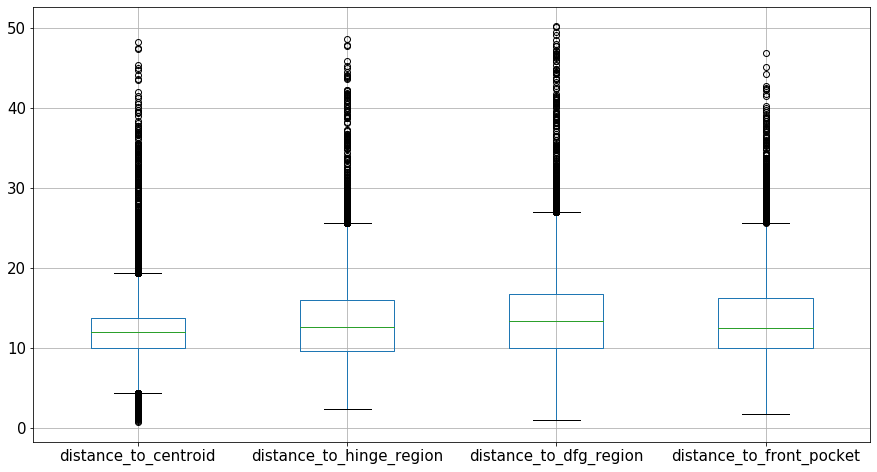

In [61]:
boxplot = all_distances.boxplot(figsize=(15,8), fontsize=15)

In [62]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_all_boxplot.png', dpi=300)